In [1]:
%load_ext autoreload
%autoreload 2
# Add parent directory into system path
import sys, os
sys.path.insert(1, os.path.abspath(os.path.normpath('..')))

In [2]:
import torch
from torch import nn
from torch.nn.init import calculate_gain
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f'CUDA {i}: {torch.cuda.get_device_name(i)}')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float32)

CUDA 0: NVIDIA GeForce GTX 1650 Ti


In [13]:
from models.Wang2020 import M2
net = M2(N_layers=8, width=32, activation=nn.ELU()).to(device)

In [4]:
import os
from utils.dataset import ImplicitDataset, RandomMeshSDFDataset

dataset_name = '../datasets/box_1f0_gyroid_4pi'
output_stl = dataset_name+'.stl'
#train_dataset = ImplicitDataset.from_file(file=dataset_name+'_train.npz', device=device)
train_dataset = RandomMeshSDFDataset(output_stl, sampling_method='importance', M=int(1e6), W=10, device=device)
print(train_dataset)

RandomMeshSDFDataset (10000 points)


In [5]:
use_random_sdf = isinstance(train_dataset, RandomMeshSDFDataset)
points = train_dataset.points if use_random_sdf else train_dataset.pde_points
sdfs = train_dataset.sdfs if use_random_sdf else train_dataset.bc_sdfs

In [14]:
from utils.optimizer import CallbackScheduler

# Optimization
## ADA
optimizer=torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-6, amsgrad=False)
lr_scheduler = CallbackScheduler([
    CallbackScheduler.reduce_lr(0.2),
    CallbackScheduler.reduce_lr(0.2),
    CallbackScheduler.init_LBFGS(
        lr=1, max_iter=20, max_eval=40, 
        tolerance_grad=1e-5, tolerance_change=1e-9,
        history_size=100,
        line_search_fn=None
    ),
    CallbackScheduler.reduce_lr(0.2)
], optimizer=optimizer, model=net, eps=1e-7, patience=300)

In [15]:
#torch.autograd.set_detect_anomaly(True)
max_epochs = 2500
PRINT_EVERY_EPOCH = 100
points.requires_grad_(True)
try:
    for epoch in range(max_epochs):
        # Training
        optimizer.zero_grad()
        y = net(points)
        loss = net.loss(y, points, points, sdfs)
        loss.backward(retain_graph=True)
      
        lr_scheduler.optimizer.step(lambda: loss)
        lr_scheduler.step_when((epoch % 500) == 499)
        lr_scheduler.step_loss(loss)
        
        if epoch % 20 == 19:
            y = net(points)
            net.adaptive_lambda(y, points, points, sdfs)

        if epoch % PRINT_EVERY_EPOCH == 0:
            print(f'#{epoch} Loss: {net._loss_PDE:.6f}, {net._loss_SDF:.6f}, {net.loss_lambda[0]:.6f}')
except KeyboardInterrupt as e:
    print('Bye bye')


#0 Loss: 2.416202, 0.399810, 1.000000
#100 Loss: 0.183002, 0.008868, 15.319479
#200 Loss: 0.347134, 0.003572, 73.196198
#300 Loss: 0.465594, 0.002321, 141.554657
#400 Loss: 0.561179, 0.001702, 232.704620
#500 Loss: 1.016000, 0.002023, 403.364777
#600 Loss: 4.227417, 0.001279, 3125.657471
#700 Loss: 8.142874, 0.001120, 7044.836914
#800 Loss: 8.955080, 0.001063, 8179.748047
#900 Loss: 13.683617, 0.001001, 13407.526367
#1000 Loss: 15.351307, 0.000960, 15712.316406
#1100 Loss: 46.109676, 0.000950, 48274.218750
#1200 Loss: 70.599899, 0.000927, 75865.703125
#1300 Loss: 86.419991, 0.000897, 96012.570312
#1400 Loss: 67.102051, 0.000870, 76819.968750
#1500 Loss: 83.913589, 0.000847, 98721.664062
#1600 Loss: 39.387188, 0.000606, 64776.886719
#1700 Loss: 21.229208, 0.000473, 44632.460938
#1800 Loss: 11.633429, 0.000373, 30866.585938
#1900 Loss: 7.884192, 0.000310, 25105.205078
#2000 Loss: 6.155494, 0.000267, 22676.054688
#2100 Loss: 5.958568, 0.000242, 24261.115234
#2200 Loss: 5.838016, 0.000218,

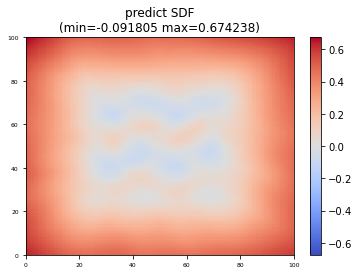

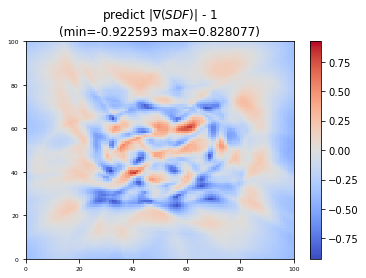

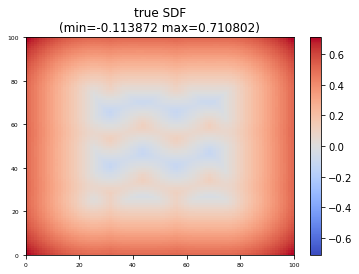

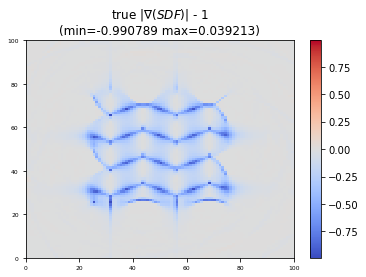

In [16]:
from utils import SDFVisualize, plot_model_weight
visualize = SDFVisualize(z_level=0, step=0.05, offset=30, nums=100, device=device)
visualize.from_nn(net, bounds_from_mesh=output_stl)
visualize.from_mesh(output_stl)